In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

## Read & Prepare Data

And transform it to BR-Like form

In [3]:
FILENAME = 'doc2vec_notesDiagnoses_OneHot100.csv'

In [14]:
def get_num_classes(df):
    num_features = 0
    num_classes = 0
    for what_type in df.dtypes:
        if(what_type == 'uint8' or what_type == 'int64'):
            num_classes += 1
        else:
            num_features += 1
    return num_features,num_classes

def extract_dataframes_for_br(df):
    dataframes = []

    for class_idx in range(num_classes):

        auxDf = df.iloc[:,0:num_features].join(df.iloc[:,num_features+class_idx])
        dataframes.append(auxDf)
    return dataframes

In [15]:
df = pd.read_csv(FILENAME)   
num_features,num_classes = get_num_classes(df)
#Randomize
df = df.sample(frac=1)
df.info()
df.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 58 to 60
Columns: 835 entries, 0 to E8783
dtypes: float64(300), int64(535)
memory usage: 653.1 KB


,0,1,2,3,4,5,6,7,8,9,...,3373,4160,34830,78702,78552,3963,2762,34690,2731,E8783
58,0.066613,-0.042797,0.008524,0.050315,-0.067958,-0.023595,0.063397,0.008572,0.033061,-0.019007,...,0,0,0,0,0,0,0,0,0,0


In [16]:
dataframes = extract_dataframes_for_br(df)
print('Original dataset has generated %d binary datasets with %d features because of the %d classes' 
      %(len(dataframes),num_features,num_classes))

Original dataset has generated 535 binary datasets with 300 features because of the 535 classes


## Model

### Hyperparams

In [17]:
learning_rate = 0.0001
batch_size = 10
num_observations = len(df.index)
num_batches = num_observations//batch_size
display_step = 1

binary = 2

print('Current config: %d batches of %d observations each one' % (num_batches,batch_size))

Current config: 10 batches of 10 observations each one


### Placeholders

In [18]:
x = tf.placeholder(tf.float32,[None,num_features],name='x')
y = tf.placeholder(tf.int64,[None],name='y')

### Core

In [19]:
W = tf.Variable(tf.truncated_normal([num_features,binary]),dtype=tf.float32)
b = tf.Variable(tf.zeros([binary]),dtype=tf.float32)

In [20]:
logits = tf.matmul(x,W) + b

#### Cost & Optimizer

In [21]:
cost = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### Test model

#### General

In [22]:
correct_prediction = tf.equal(tf.argmax(logits, 1), y)

num_correct_prediction = tf.count_nonzero(correct_prediction)

general_acc = tf.divide(num_correct_prediction,tf.cast(tf.size(y),dtype=tf.int64))

#### Positive class

In [23]:
#Add pred and labels values together into another tensor
adds = tf.add(x=tf.argmax(logits,1),y=y)
#The number of '2' values is the number of correct predictions for the positive (minoritary) class
positive_correct = tf.equal(adds, 2)

#Count non-zero to count 'True', in other words, correct positive class predicted labels
num_positive_correct = tf.count_nonzero(positive_correct)

#Positive class acc
positive_acc = tf.divide(num_positive_correct,tf.count_nonzero(y))

#### Prepare data for train

In [25]:
x_data = dataframes[0].iloc[:,:-1].as_matrix()
y_data = dataframes[0].iloc[:,-1:].as_matrix().reshape(-1)

In [26]:
x_data[0,:],y_data[0]

(array([  6.66133194e-02,  -4.27968934e-02,   8.52365134e-03,
          5.03150942e-02,  -6.79579254e-02,  -2.35952286e-02,
          6.33965680e-02,   8.57160332e-03,   3.30608942e-02,
         -1.90072299e-02,   8.93911637e-02,   3.83825214e-02,
         -2.70095421e-02,   4.90236672e-02,   1.47340545e-01,
          1.92904440e-03,  -8.72517717e-03,   5.55967817e-02,
         -3.17076703e-02,  -3.81414689e-02,   5.83568547e-03,
         -1.50927040e-02,   1.16285379e-01,   8.24728878e-02,
         -1.01540023e-02,   2.26949644e-02,  -4.60975853e-02,
          3.56762347e-02,  -3.43591758e-02,   1.22801696e-01,
         -1.18407246e-01,   9.42559677e-02,   1.35329224e-01,
         -7.44634516e-03,  -7.05220168e-02,   1.01508232e-02,
          3.22558108e-02,  -1.61774594e-02,  -2.88023999e-02,
          1.77554070e-02,   3.20974519e-02,   6.22752276e-02,
         -1.23652815e-02,   4.31431708e-02,  -2.61289346e-02,
         -9.94543380e-03,   3.64910760e-02,   2.04827292e-02,
        

### Train

In [27]:
num_epochs = 10000
display_freq = num_epochs//10

loss_list = []
loss_list_batch = []

positive_acc_list = []
gen_acc_list = []

# Launch the graph
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    
    
    for step in range(num_epochs):

    
        for batch_idx in range(num_batches):
            batchx = x_data[batch_idx*batch_size:batch_idx*batch_size+batch_size,:]
            batchy = y_data[batch_idx*batch_size:batch_idx*batch_size+batch_size]      
            
            feed = {x: batchx, y: batchy}

            _,_loss,_softmax,_y = sess.run([optimizer,cost,logits,y], feed_dict=feed)
            
            loss_list_batch.append(np.average(_loss)) #Store av. batch loss
            
        #Add the av. loss of the batch to the loss list
        loss_list.append(np.average(loss_list_batch))
        loss_list_batch = []
        
        if (step % display_freq == 0):
            _positive_acc,_gen_acc = sess.run([positive_acc,general_acc],feed_dict={x : x_data, y : y_data})
            positive_acc_list.append(_positive_acc)
            gen_acc_list.append(_gen_acc)
            
            print('At epoch %d - Loss: %.3f' %(step,np.average(_loss)))
            
    
    print("Train finished")
    feed_test = {x : x_data, y : y_data}
    _y,_softmax,_softargmax,_positive_acc,_gen_acc = sess.run([y,logits,tf.argmax(logits,1),positive_acc,general_acc],feed_dict=feed_test)
    print('Final unfair evaluation positive class accuracy: %.2f' % _positive_acc)
          

    

At epoch 0 - Loss: 0.185
At epoch 1000 - Loss: 0.005
At epoch 2000 - Loss: 0.002
At epoch 3000 - Loss: 0.001
At epoch 4000 - Loss: 0.000
At epoch 5000 - Loss: 0.000
At epoch 6000 - Loss: 0.000
At epoch 7000 - Loss: 0.000
At epoch 8000 - Loss: 0.000
At epoch 9000 - Loss: 0.000
Train finished
Final unfair evaluation positive class accuracy: 1.00


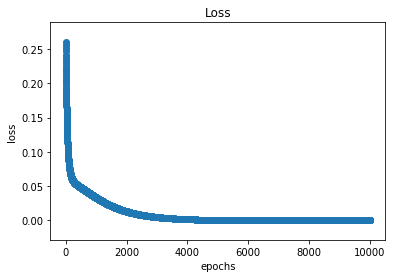

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list)),y=loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show();

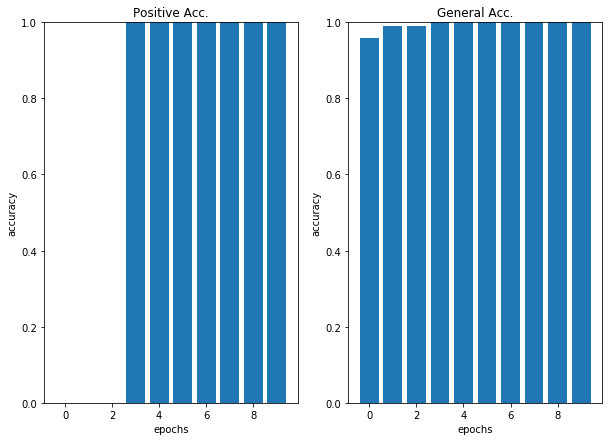

In [29]:
fig,axes = plt.subplots(1,2,figsize=(10,7))

axes[0].set_title('Positive Acc.')
axes[0].bar(left=np.arange(0,len(positive_acc_list)),height=positive_acc_list)
axes[0].set_ylim(0,1)
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')

axes[1].set_title('General Acc.')
axes[1].bar(left=np.arange(0,len(gen_acc_list)),height=gen_acc_list)
axes[1].set_ylim(0,1)
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('accuracy')

plt.show();

In [33]:
_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [31]:
_softargmax

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)